# Mean Pairwise TracIn(Ideal/CP) of Training Examples on Test-Set

I.e., mean influence a given document from the training data had on all examples in a test set.

Requirements:
 - Training dataset: A sample from the (pretraining/finetuning) data 
 - Test dataset: A set of examples for wich training data influence is to be estimated (as a group!)

Use Case:
 - You have multiple sets ([noisy, not noisy, ood, etc] or (verbalized, percentage, no ce) or (math, news, books, child directed)]
 - You want to know the most useful documents from the training data when predicting examples from those sets

Why not per-train-test-instance?
- Theoretically possible but not implemented (would not have made sense for BabyLM)
- Way more expensive to compute across checkpoints

$\sum_i=0^k$

In [1]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
from datasets import load_dataset
import plotting
from util import tokenize_tulu_dataset, get_checkpoints_olmo
import pandas as pd
import swifter

import torch
from transformers import AutoTokenizer

In [2]:
# import argparse
# import os

# import setproctitle
# from dotenv import load_dotenv
# load_dotenv()
# import wandb

# from util import batch 

# from functools import partial
# from multiprocessing.pool import ThreadPool



# import json

# from datasets import load_dataset

model_name = "loris3/stratified_equitoken_10m_curriculum_random"
dataset_train_name ="loris3/stratified_equitoken_10m_curriculum"
dataset_train_split_name = "train"
dataset_test_name = "loris3/stratified_equitoken_10m_curriculum"
dataset_test_split_name = "train"


# gradient_output_dir_train = os.path.join("./gradients", os.path.basename(model_name), os.path.basename(dataset_train_name), dataset_train_split_name)
# gradient_output_dir_test = os.path.join("./gradients", os.path.basename(model_name), os.path.basename(dataset_test_name), dataset_test_split_name)


# if not os.path.exists("./influence"):
#     os.makedirs("./influence")
    
# influence_output_dir = os.path.join("./influence", os.path.basename(model_name), "_".join([os.path.basename(dataset_train_name), dataset_train_split_name, os.path.basename(dataset_test_name), dataset_test_split_name]))
# if not os.path.exists(influence_output_dir):
#     os.makedirs(influence_output_dir)


# os.environ["TOKENIZERS_PARALLELISM"] = "True"




# import torch


# import logging
# logging.basicConfig(
#                     level=logging.INFO,
#                     format='%(asctime)s - %(levelname)s - %(message)s')




# import util


# import time

# import datasets




# # TODO we only need to know the lenght of the dataset here


# dataset_train = load_dataset(dataset_train_name)[dataset_train_split_name] 

# dataset_test = load_dataset(dataset_test_name)[dataset_test_split_name] 








# import util


# ##########################################


# import torch 
# import time
# from concurrent.futures import ThreadPoolExecutor



# #########################################
# from multiprocessing import Pool, current_process, Queue
# import time 
# import datetime
# import os
# from pathlib import Path
# import torch
# from itertools import cycle


# import sys

# from transformers import RobertaTokenizerFast

# tokenizer = RobertaTokenizerFast.from_pretrained(model_name, max_len=512)


# from util import get_checkpoints_hub
# checkpoints =  get_checkpoints_hub(model_name)

# from util import DeterministicDataCollatorForLanguageModeling




# import sys

# from multiprocessing import Pool, Manager


# import shutil




# checkpoint = checkpoints[0]
    
# ###############

# chunks_train = [ os.path.join(gradient_output_dir_train, os.path.basename(checkpoint), str(i) + "_" + str(i + 1000)) for i in list(range(0, len(dataset_train), 1000))]

# chunks_test = [ os.path.join(gradient_output_dir_test, os.path.basename(checkpoint), str(i) + "_" + str(i + 1000)) for i in range(0, len(dataset_test), 1000)]


# device = "cpu"

# load_fn = lambda chunk_path: torch.load(chunk_path, weights_only=True, map_location=device).flatten(1)
# chunks_a = None
# with ThreadPoolExecutor(max_workers=50) as executor:
#     chunks_a = list(executor.map(lambda task: (load_fn(task)), chunks_train))
# chunks_b = None
# with ThreadPoolExecutor(max_workers=50) as executor:
#     chunks_b = list(executor.map(lambda task: (load_fn(task)), chunks_test))
# ###############



# c = torch.cat(chunks_a, dim=0)
# del chunks_a
# d = torch.cat(chunks_b, dim=0)
# del chunks_b

# assert c.shape[0] == len(dataset_train)

# simple = torch.matmul(c, d.T)

# simple.shape

In [41]:
def convert_to_float(value):
    if value and isinstance(value, str):
        value = value.replace("tokens", "")
        num = ''.join([char for char in value if char.isdigit()])
        suffix = ''.join([char for char in value if char.isalpha()])
        num = float(num)
        if suffix == 'B':
            num *= 1e9  # Billion
        elif suffix == 'M':
            num *= 1e6  # Million
        elif suffix == 'K':
            num *= 1e3  # Thousand
        return num
    return None


In [42]:
selection = []

In [51]:
checkpoints = pd.DataFrame(get_checkpoints_olmo())
checkpoints.columns = ["name"]
checkpoints[['stage', 'ingredient', 'step', 'tokens']] = checkpoints["name"].str.extract(r'(stage\d+)-(ingredient\d+)?-?(step\d+)?-?(tokens\d+\w+)?')
checkpoints.set_index("name")

checkpoints["step"] = pd.to_numeric(checkpoints["step"].str.replace("step",""))
checkpoints["stage"] = pd.to_numeric(checkpoints["stage"].str.replace("stage",""))
checkpoints['tokens'] = checkpoints['tokens'].apply(convert_to_float)

# checkpoints = checkpoints[checkpoints["stage"] == "stage2"]

In [52]:
checkpoints

,name,stage,ingredient,step,tokens
0,stage1-step150-tokens1B,1.0,NaN,150.0,1.000000e+09
1,stage1-step600-tokens3B,1.0,NaN,600.0,3.000000e+09
2,stage1-step700-tokens3B,1.0,NaN,700.0,3.000000e+09
3,stage1-step850-tokens4B,1.0,NaN,850.0,4.000000e+09
4,stage1-step900-tokens4B,1.0,NaN,900.0,4.000000e+09
...,...,...,...,...,...
960,stage2-ingredient3-step9000-tokens38B,2.0,ingredient3,9000.0,3.800000e+10
961,stage2-ingredient3-step10000-tokens42B,2.0,ingredient3,10000.0,4.200000e+10
962,stage2-ingredient3-step11000-tokens47B,2.0,ingredient3,11000.0,4.700000e+10
963,stage2-ingredient3-step11931-tokens50B,2.0,ingredient3,11931.0,5.000000e+10


<Axes: xlabel='step'>

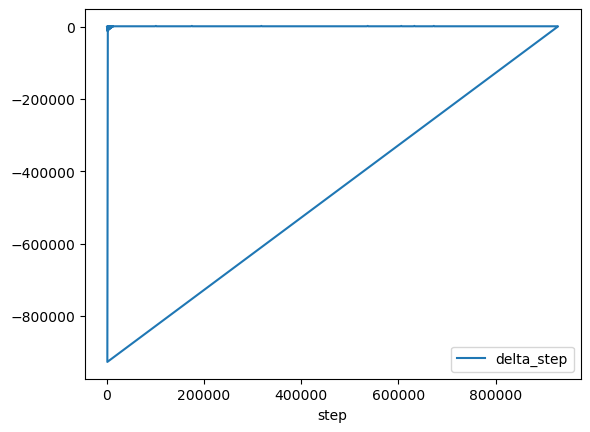

In [57]:
checkpoints['delta_step'] = checkpoints['step'].diff()

checkpoints[['step', 'delta_step']].plot(x='step', y='delta_step', kind='line')


In [58]:
checkpoints['delta_step']

0         NaN
1       450.0
2       100.0
3       150.0
4        50.0
        ...  
960    1000.0
961    1000.0
962    1000.0
963     931.0
964       NaN
Name: delta_step, Length: 965, dtype: float64

<Axes: xlabel='tokens'>

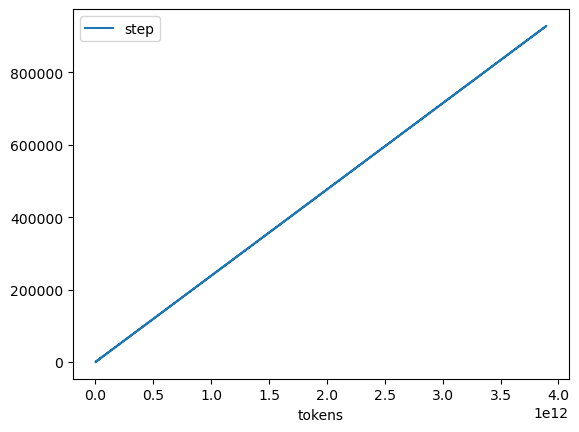

In [59]:
checkpoints[["step", "tokens"]].plot(y='step', x='tokens', kind='line')


In [60]:
checkpoints

,name,stage,ingredient,step,tokens,delta_step
0,stage1-step150-tokens1B,1.0,NaN,150.0,1.000000e+09,NaN
1,stage1-step600-tokens3B,1.0,NaN,600.0,3.000000e+09,450.0
2,stage1-step700-tokens3B,1.0,NaN,700.0,3.000000e+09,100.0
3,stage1-step850-tokens4B,1.0,NaN,850.0,4.000000e+09,150.0
4,stage1-step900-tokens4B,1.0,NaN,900.0,4.000000e+09,50.0
...,...,...,...,...,...,...
960,stage2-ingredient3-step9000-tokens38B,2.0,ingredient3,9000.0,3.800000e+10,1000.0
961,stage2-ingredient3-step10000-tokens42B,2.0,ingredient3,10000.0,4.200000e+10,1000.0
962,stage2-ingredient3-step11000-tokens47B,2.0,ingredient3,11000.0,4.700000e+10,1000.0
963,stage2-ingredient3-step11931-tokens50B,2.0,ingredient3,11931.0,5.000000e+10,931.0


In [61]:
import numpy as np



In [62]:
n = 10
checkpoints_ = checkpoints[~checkpoints["ingredient"].isin(["ingredient2", "ingredient3"])].reset_index(drop=True)
checkpoints_.iloc[1::int(np.ceil( len(checkpoints_) / n ))]


,name,stage,ingredient,step,tokens,delta_step
1,stage1-step600-tokens3B,1.0,NaN,600.0,3.000000e+09,450.0
96,stage1-step91000-tokens382B,1.0,NaN,91000.0,3.820000e+11,1000.0
191,stage1-step188000-tokens789B,1.0,NaN,188000.0,7.890000e+11,1000.0
286,stage1-step283000-tokens1187B,1.0,NaN,283000.0,1.187000e+12,1000.0
381,stage1-step379000-tokens1590B,1.0,NaN,379000.0,1.590000e+12,1000.0
476,stage1-step474000-tokens1989B,1.0,NaN,474000.0,1.989000e+12,1000.0
571,stage1-step570000-tokens2391B,1.0,NaN,570000.0,2.391000e+12,1000.0
666,stage1-step667000-tokens2798B,1.0,NaN,667000.0,2.798000e+12,1000.0
761,stage1-step763000-tokens3201B,1.0,NaN,763000.0,3.201000e+12,1000.0
856,stage1-step858000-tokens3599B,1.0,NaN,858000.0,3.599000e+12,1000.0


In [63]:
checkpoints_.iloc[::int(np.ceil( len(checkpoints_) / n ))]


,name,stage,ingredient,step,tokens,delta_step
0,stage1-step150-tokens1B,1.0,NaN,150.0,1.000000e+09,NaN
95,stage1-step90000-tokens378B,1.0,NaN,90000.0,3.780000e+11,1000.0
190,stage1-step187000-tokens785B,1.0,NaN,187000.0,7.850000e+11,1000.0
285,stage1-step282000-tokens1183B,1.0,NaN,282000.0,1.183000e+12,1000.0
380,stage1-step378000-tokens1586B,1.0,NaN,378000.0,1.586000e+12,1000.0
475,stage1-step473000-tokens1984B,1.0,NaN,473000.0,1.984000e+12,1000.0
570,stage1-step569000-tokens2387B,1.0,NaN,569000.0,2.387000e+12,1000.0
665,stage1-step666000-tokens2794B,1.0,NaN,666000.0,2.794000e+12,1000.0
760,stage1-step762000-tokens3197B,1.0,NaN,762000.0,3.197000e+12,1000.0
855,stage1-step857000-tokens3595B,1.0,NaN,857000.0,3.595000e+12,1000.0


In [64]:
checkpoints_

,name,stage,ingredient,step,tokens,delta_step
0,stage1-step150-tokens1B,1.0,NaN,150.0,1.000000e+09,NaN
1,stage1-step600-tokens3B,1.0,NaN,600.0,3.000000e+09,450.0
2,stage1-step700-tokens3B,1.0,NaN,700.0,3.000000e+09,100.0
3,stage1-step850-tokens4B,1.0,NaN,850.0,4.000000e+09,150.0
4,stage1-step900-tokens4B,1.0,NaN,900.0,4.000000e+09,50.0
...,...,...,...,...,...,...
936,stage2-ingredient1-step9000-tokens38B,2.0,ingredient1,9000.0,3.800000e+10,1000.0
937,stage2-ingredient1-step10000-tokens42B,2.0,ingredient1,10000.0,4.200000e+10,1000.0
938,stage2-ingredient1-step11000-tokens47B,2.0,ingredient1,11000.0,4.700000e+10,1000.0
939,stage2-ingredient1-step11931-tokens50B,2.0,ingredient1,11931.0,5.000000e+10,931.0


In [65]:
checkpoints["ingredient"] not in ["ingredient2","ingredient3"]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [66]:
stage1 = checkpoints[checkpoints["stage"] == "stage1"]

In [26]:
len(stage1)

928

In [ ]:
n = 3
selection_stage1 = stage1.iloc[range(0, len(stage1), len(stage1)//n)][1:]
selection.append(selection_stage1)
selection_stage1

,name,stage,ingredient,step,tokens
309,stage1-step306000-tokens1284B,stage1,NaN,step306000,tokens1284B
618,stage1-step618000-tokens2593B,stage1,NaN,step618000,tokens2593B
927,stage1-step928646-tokens3896B,stage1,NaN,step928646,tokens3896B


In [23]:
stage2 = checkpoints[checkpoints["stage"] == "stage2"]

In [ ]:
dsaf

NameError: name 'dsaf' is not defined

In [6]:
# checkpoints

In [7]:
# checkpoints

In [8]:
# # dataset_train_name = "allenai/tulu-v2-sft-mixture"
# # dataset_train_split_name = "train[:1%]"

# # dataset_test_name = "allenai/tulu-v2-sft-mixture"
# # dataset_test_split_name="train[5%:6%]"

# model_name = "allenai/OLMo-2-1124-7B"

# dataset = tokenize_tulu_dataset("allenai/tulu-v2-sft-mixture", "train[:1%]")
influence_output_dir = os.path.join("./influence", os.path.basename(model_name), "_".join([os.path.basename(dataset_train_name), dataset_train_split_name, os.path.basename(dataset_test_name), dataset_test_split_name]))


In [9]:
influence_output_dir

'./influence/stratified_equitoken_10m_curriculum_random/stratified_equitoken_10m_curriculum_train_stratified_equitoken_10m_curriculum_train'

In [10]:
os.listdir(influence_output_dir)

['checkpoint-6174']

In [11]:
# dataset_train = tokenize_tulu_dataset(dataset_train_name, dataset_train_split_name)
# dataset_test = tokenize_tulu_dataset(dataset_train_name, dataset_test_split_name)

In [12]:
tokenizer = AutoTokenizer.from_pretrained("allenai/OLMo-2-1124-7B")

In [13]:
# {(result_checkpoint): torch.load(os.path.join(influence_output_dir,result_checkpoint),weights_only=True,map_location="cpu").float().numpy() for result_checkpoint in os.listdir(influence_output_dir)}

In [14]:
data = {(result_checkpoint): torch.load(os.path.join(influence_output_dir,result_checkpoint),weights_only=True,map_location="cpu").to(dtype=torch.float16).numpy() for result_checkpoint in os.listdir(influence_output_dir)}

In [15]:
d = data["checkpoint-6174"]

In [16]:
from sklearn.preprocessing import minmax_scale #  TODO choose

import numpy as np

In [34]:
e_x = np.exp(d - np.max(d))
d_sm = e_x / e_x.sum(axis=0)

/tmp/ipykernel_990606/2514398711.py:2: RuntimeWarning: invalid value encountered in divide
  d_sm = e_x / e_x.sum(axis=0)


In [18]:
d_normalized = minmax_scale(d, axis=0)

In [19]:
d_normalized.shape

(100000, 100000)

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns


<Axes: ylabel='Count'>

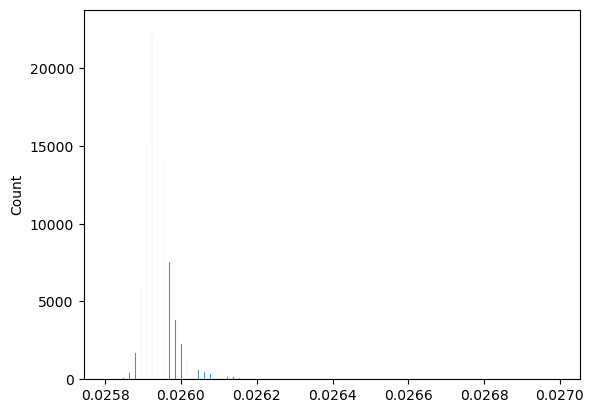

In [24]:
m = d_normalized.mean(axis=1)

sns.histplot(m)

In [33]:
d_sm

array([[0.368, 0.368, 0.368, ..., 0.368, 0.368, 0.368],
       [0.368, 0.368, 0.368, ..., 0.368, 0.368, 0.368],
       [0.368, 0.368, 0.368, ..., 0.368, 0.368, 0.368],
       ...,
       [0.368, 0.368, 0.368, ..., 0.368, 0.368, 0.368],
       [0.368, 0.368, 0.368, ..., 0.368, 0.368, 0.368],
       [0.368, 0.368, 0.368, ..., 0.368, 0.368, 0.368]],
      shape=(100000, 100000), dtype=float16)

In [29]:
m_sm.min()

np.float16(0.3677)

In [23]:
trhzdfcx

NameError: name 'trhzdfcx' is not defined

In [ ]:
z_scores = (data["checkpoint-6174"] - data["checkpoint-6174"].mean())/data["checkpoint-6174"].std()

In [ ]:
z_scores

In [15]:
# a = simple.float().numpy()
# b = data["checkpoint-6174"].to_numpy()#[:2000,:]
# (np.abs(a-b)).mean()
# np.allclose(a,b, rtol=10e-3)

In [16]:
# df = pd.DataFrame(torch.load(os.path.join(influence_output_dir,os.listdir(influence_output_dir)[0]),weights_only=True,map_location="cpu"))

In [17]:
# df.to_parquet("a")

In [18]:
# ddf.head()

In [19]:
# dff

In [20]:
# ddf.compute()

In [21]:
# ddf

In [22]:
# ddf.head()

In [ ]:
gtsr4qartgsf

In [ ]:
import pandas as pd
import swifter

import numpy as np


df = pd.DataFrame(np.random.randn(100, 3))

df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [ ]:
äkrhipz98ur09iekovfmlkgnht9rifko

In [36]:
import numpy as np

In [ ]:
pd.DataFrame(data)

In [ ]:
df = pd.DataFrame({(result_checkpoint): torch.load(os.path.join(influence_output_dir,result_checkpoint),weights_only=True,map_location="cpu").float().numpy() for result_checkpoint in os.listdir(influence_output_dir)})
df.sort_index(axis=1)
print(len(df))

In [ ]:
torch.load(os.path.join(influence_output_dir,result_checkpoint),weights_only=True,map_location="cpu").float().numpy()

In [ ]:
df

In [ ]:
df = pd.DataFrame({(result_checkpoint): torch.load(os.path.join(influence_output_dir,result_checkpoint),weights_only=True,map_location="cpu").numpy().flatten() for result_checkpoint in os.listdir(influence_output_dir)})
df.sort_index(axis=1)
print(len(df))

df = df.reindex(sorted(df.columns, reverse=False), axis=1)
influence_cols = df.columns
df["total"] = df.sum(axis=1)
df["text"] = dataset_train.to_pandas()["input_ids"].apply(lambda x: tokenizer.decode(x, skip_special_tokens=True))
# df["document_lenght"] = df["text"].str.split().str.len()

In [ ]:
pd.set_option('display.max_colwidth', 1000)
df.sort_values(by="total", ascending=False)

In [ ]:
len(dataset_train)

In [ ]:
dataset[0]["input_ids"]

In [ ]:
dataset[0]

In [16]:
from pathlib import Path
import numpy as np





In [ ]:
checkpoint_names

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch




In [ ]:

message = ["Language modeling is "]

oldmos = []
for i in [1,100,500,900]:
    
    olmo = AutoModelForCausalLM.from_pretrained("allenai/OLMo-2-1124-7B", revision=checkpoint_names[i])
    inputs = tokenizer(message, return_tensors='pt', return_token_type_ids=False)
    # optional verifying cuda
    inputs = {k: v.to('cuda') for k,v in inputs.items()}
    olmo = olmo.to('cuda')
    oldmos.append(olmo)
    response = olmo.generate(**inputs, max_new_tokens=100, do_sample=True, top_k=50, top_p=0.95)
    print(tokenizer.batch_decode(response, skip_special_tokens=True)[0])

In [ ]:

checkpoints_stage_2

In [ ]:
checkpoints_stage1